In [33]:
using AutoRisk
using PGFPlots

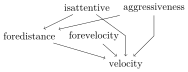

In [34]:
d = JLD.load("../../data/bayesnets/base_test.jld") 
base_bn = d["bn"]
var_edges = d["var_edges"]

d = JLD.load("../../data/bayesnets/prop_test.jld") 
prop_bn = d["bn"]

In [41]:
# build the generator
sampler = UniformAssignmentSampler(var_edges)
dynamics = Dict(:velocity=>:forevelocity)
num_veh_per_lane = 20
min_p = get_passive_behavior_params(err_p_a_to_i = .01)
max_p = get_aggressive_behavior_params(err_p_a_to_i = .01)
context = IntegratedContinuous(.1, 1)
behgen = CorrelatedBehaviorGenerator(context, min_p, max_p)
gen = BayesNetLaneGenerator(base_bn, prop_bn, sampler, dynamics, num_veh_per_lane, behgen);

In [42]:
num_lanes = 3
roadway = gen_straight_roadway(num_lanes)
scene = Scene(num_veh_per_lane * num_lanes)
models = Dict{Int,DriverModel}()
rand!(gen, roadway, scene, models, 2);

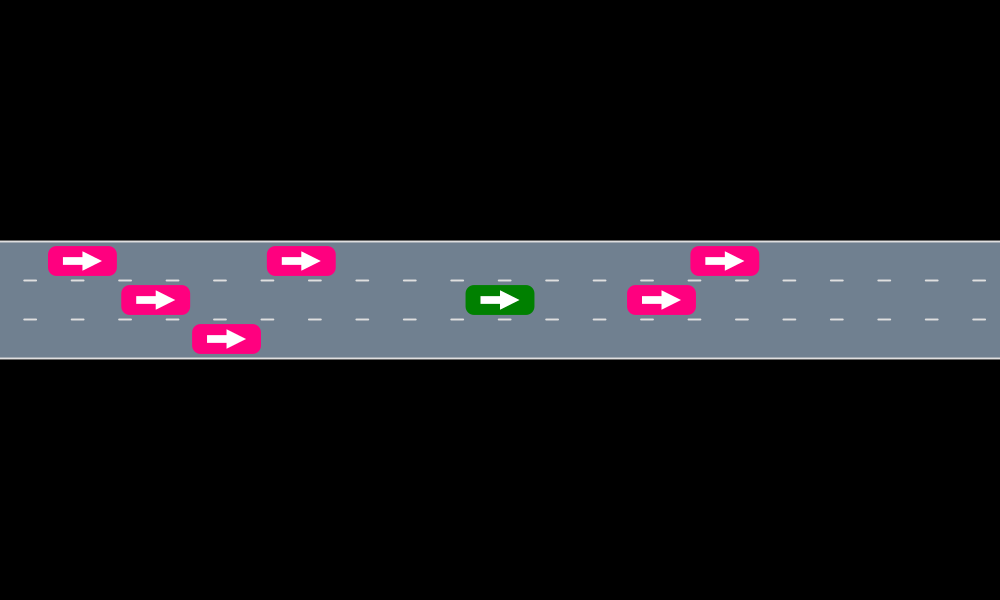

In [48]:
carcolors = Dict{Int,Colorant}()
carcolors[39] = colorant"green"
render(scene, roadway, cam=CarFollowCamera(39, 13.), car_colors=carcolors)

In [38]:
# scene feature extractors
function get_static_features(scene::Scene, roadway::Roadway)
    # feature containers, censors
    timegaps = zeros(Float64, length(scene))
    timegap_censor_hi = 10.
    ttcs = zeros(Float64, length(scene))
    ttc_censor_hi = 30.
    velocities = zeros(Float64, length(scene))
    distance_fores = zeros(Float64, length(scene))
    distance_fore_censor_hi = 100.
    
    for veh_idx in 1:length(scene)
        ego_veh = scene.vehicles[veh_idx]
        velocities[veh_idx] = ego_veh.state.v
        
        neigh = get_neighbor_fore_along_lane(scene, veh_idx, roadway)
        
        # if the fore vehicle does not exist then set as censor high
        if neigh.ind == 0
            timegaps[veh_idx] = timegap_censor_hi
            distance_fores[veh_idx] = distance_fore_censor_hi
            ttcs[veh_idx] = ttc_censor_hi
        else
            # get both vehicles 
            rear_veh = scene.vehicles[veh_idx]
            fore_veh = scene.vehicles[neigh.ind]
            
            # want the time for the rear vehicle's front to reach the fore vehicle's back
            v = rear_veh.state.v
            
            # first term is distance between centers
            # second moves from fore vehicle center to back bumper
            # third moves from rear vehicle center to front bumper
            Δs = (fore_veh.state.posF.s - rear_veh.state.posF.s) - (fore_veh.def.length / 2) - (rear_veh.def.length / 2)
            timegaps[veh_idx] = min(Δs / v, timegap_censor_hi)
            
            # distance fore
            distance_fores[veh_idx] = min(Δs, distance_fore_censor_hi)
            
            # time to collision
            Δv = fore_veh.state.v - rear_veh.state.v
            if Δv < 0.
                ttcs[veh_idx] = min(max(-1 * Δs / Δv, 0.), ttc_censor_hi)
            else # this means fore vehicle moving away too quickly
                ttcs[veh_idx] = ttc_censor_hi
            end
            
        end
    end
    return timegaps, ttcs, velocities, distance_fores
end

get_static_features (generic function with 1 method)

BayesNets.CPDs.CategoricalCPD{Distributions.Categorical{Float64}}[BayesNets.CPDs.CategoricalCPD{Distributions.Categorical{Float64}}(:isattentive,Symbol[],Int64[],Distributions.Categorical{Float64}[Distributions.Categorical{Float64}(K=2, p=[0.050038,0.949962])]),BayesNets.CPDs.CategoricalCPD{Distributions.Categorical{Float64}}(:aggressiveness,Symbol[],Int64[],Distributions.Categorical{Float64}[Distributions.Categorical{Float64}(K=4, p=[0.240608,0.253485,0.254398,0.251508])]),BayesNets.CPDs.CategoricalCPD{Distributions.Categorical{Float64}}(:foredistance,Symbol[:aggressiveness,:isattentive],[4,2],Distributions.Categorical{Float64}[Distributions.Categorical{Float64}(
K: 10
p: [0.0130435,0.295652,0.265217,0.173913,0.0913043,0.0565217,0.0391304,0.026087,0.0217391,0.0173913]
)
,Distributions.Categorical{Float64}(
K: 10
p: [0.0,0.252918,0.435798,0.14786,0.0700389,0.0350195,0.0272374,0.0194553,0.0116732,0.0]
)
,Distributions.Categorical{Float64}(
K: 10
p: [0.0,0.105485,0.49789,0.248945,0.09282

In [39]:
num_scenes, num_veh, num_lanes = 1000, num_veh_per_lane , 1
emergent = Dict{String, Array{Float64}}()
emergent["timegap"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["ttc"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["velocity"] = zeros(Float64, num_scenes * num_veh * num_lanes)
emergent["distance_fore"] = zeros(Float64, num_scenes * num_veh * num_lanes)
for scene_idx in 1:num_scenes
    rand!(gen, roadway, scene, models, scene_idx)
    timegaps, ttcs, velocities, distance_fores = get_static_features(scene, roadway)
    s = (scene_idx - 1) * num_lanes * num_veh
    e = s + num_lanes * num_veh
    emergent["timegap"][s+1:e] = timegaps
    emergent["ttc"][s+1:e] = ttcs
    emergent["velocity"][s+1:e] = velocities
    emergent["distance_fore"][s+1:e] = distance_fores
end

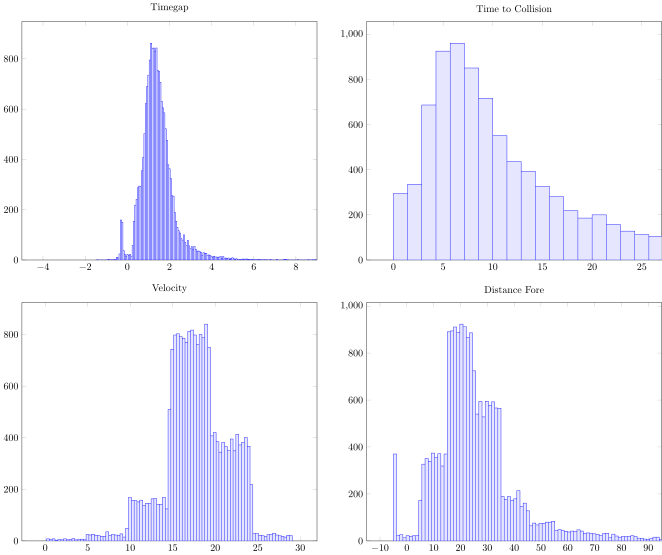

In [40]:
# analyze emergent behavior
g = GroupPlot(2, 2, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
nbins = 100
timegap_axis = Axis(Plots.Histogram(emergent["timegap"], bins=nbins), 
                    ymin=0, 
                    xmax=9, 
                    xmin=-5,
                    width="12cm",
                    height="10cm",
                    title="Timegap")
push!(g, timegap_axis)
ttc_axis = Axis(Plots.Histogram(emergent["ttc"], bins=nbins), 
                    ymin=0, 
                    xmax=27,
                    width="12cm",
                    height="10cm",
                    title="Time to Collision")
push!(g, ttc_axis)
velocity_axis = Axis(Plots.Histogram(emergent["velocity"], bins=nbins), 
                    ymin=0,  
                    width="12cm",
                    height="10cm",
                    title="Velocity")
push!(g, velocity_axis)
distance_fore_axis = Axis(Plots.Histogram(emergent["distance_fore"], bins=nbins), 
                    ymin=0,  
                    xmax=95,
                    width="12cm",
                    height="10cm",
                    title="Distance Fore")
push!(g, distance_fore_axis)
g